In [1]:
import os 
os.environ['THEANO_FLAGS'] = 'optimizer_including=cudnn, force_device=True, mode=FAST_RUN, device=cuda*,linker=cvm, optimizer=fast_compile'
#print(os.path.expanduser('~/.theanorc.txt'))

In [2]:
# import os
# os.environ["MKL_THREADING_LAYER"]="GNU"
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 
# os.environ["OMP_NUM_THREADS"] = "2" 

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.tensor import fft
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import theano.tensor.signal.conv
import exoplanet as xo
import scipy.signal

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/malte/anaconda3/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/malte/anaconda3/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/malte/anaconda3/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 569, in pygpu.gpuarray.pygpu_init
ValueError: invalid literal for int() with base 10: '*'


<ErrorbarContainer object of 3 artists>

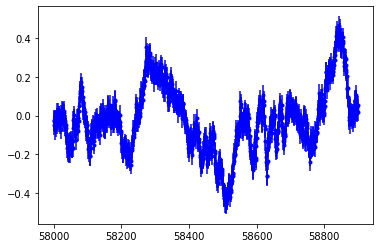

In [3]:
X_driv,f_driv = np.loadtxt('drivingfunction.txt', delimiter=',', usecols=(0,1), unpack=True)
err_driv=np.ones(len(f_driv))*0.05
plt.errorbar(X_driv, f_driv, err_driv, fmt='b.')

In [4]:
N_k = 50#how many paramters do we have?
T_rec=2.0*(max(X_driv)-min(X_driv))#recurrence time
omg_low=np.pi/T_rec#low frequency, also domg, ALSO omg_0?
domg=omg_low
omg_high=N_k*omg_low#high frequency
omg_k=np.linspace(omg_low,omg_high,N_k)
P_0=1.0 #value from power spectrum, what is this value? script say to set it to "average of 1st 3 frequency amplitudes"
omg_0=omg_low#starting frequency?
sigma_k=np.sqrt((P_0*domg/2.0))*(omg_0/omg_k)
#f=np.array(np.zeros(len(X_driv)))
# #Fourier coefficients
# S_k = pm.Normal('S_k', mu=0.0, sigma=sigma_k,shape=N_k)
# C_k = pm.Normal('C_k',mu=0.0,sigma=sigma_k,shape=N_k)

# #find way to avoid for loop in theano
#for i in range(0,N_k):
#    f[i] = tt.sum(C_k*tt.cos(omg_k*t[i])+S_k*tt.sin(omg_k*t[i]))

In [7]:
with pm.Model() as model:
    #Fourier coefficients
    S_k = pm.Normal('S_k', mu=0.0, sigma=sigma_k,shape=N_k)
    C_k = pm.Normal('C_k',mu=0.0,sigma=sigma_k,shape=N_k)
    #find way to avoid for loop in theano
    
    f,updates=theano.scan(fn=lambda X_driv:tt.sum(C_k*tt.cos(omg_k*X_driv)+S_k*tt.sin(omg_k*X_driv)),
                         sequences=[X_driv])
    f_save=pm.Deterministic('f_save',f)
    likelihood = pm.Normal('f_driv', mu=f, sigma=err_driv, observed=f_driv)
    
    tracetransfer = pm.sample(1000,tune=1000,init='nuts',n_init=1000)

/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/malte/anaconda3/lib/python3.7/site-packages/theano/

/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_

/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/plot_utils.py:630: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1000) in plot_posterior, generating only 40 plots
  SyntaxWarning,


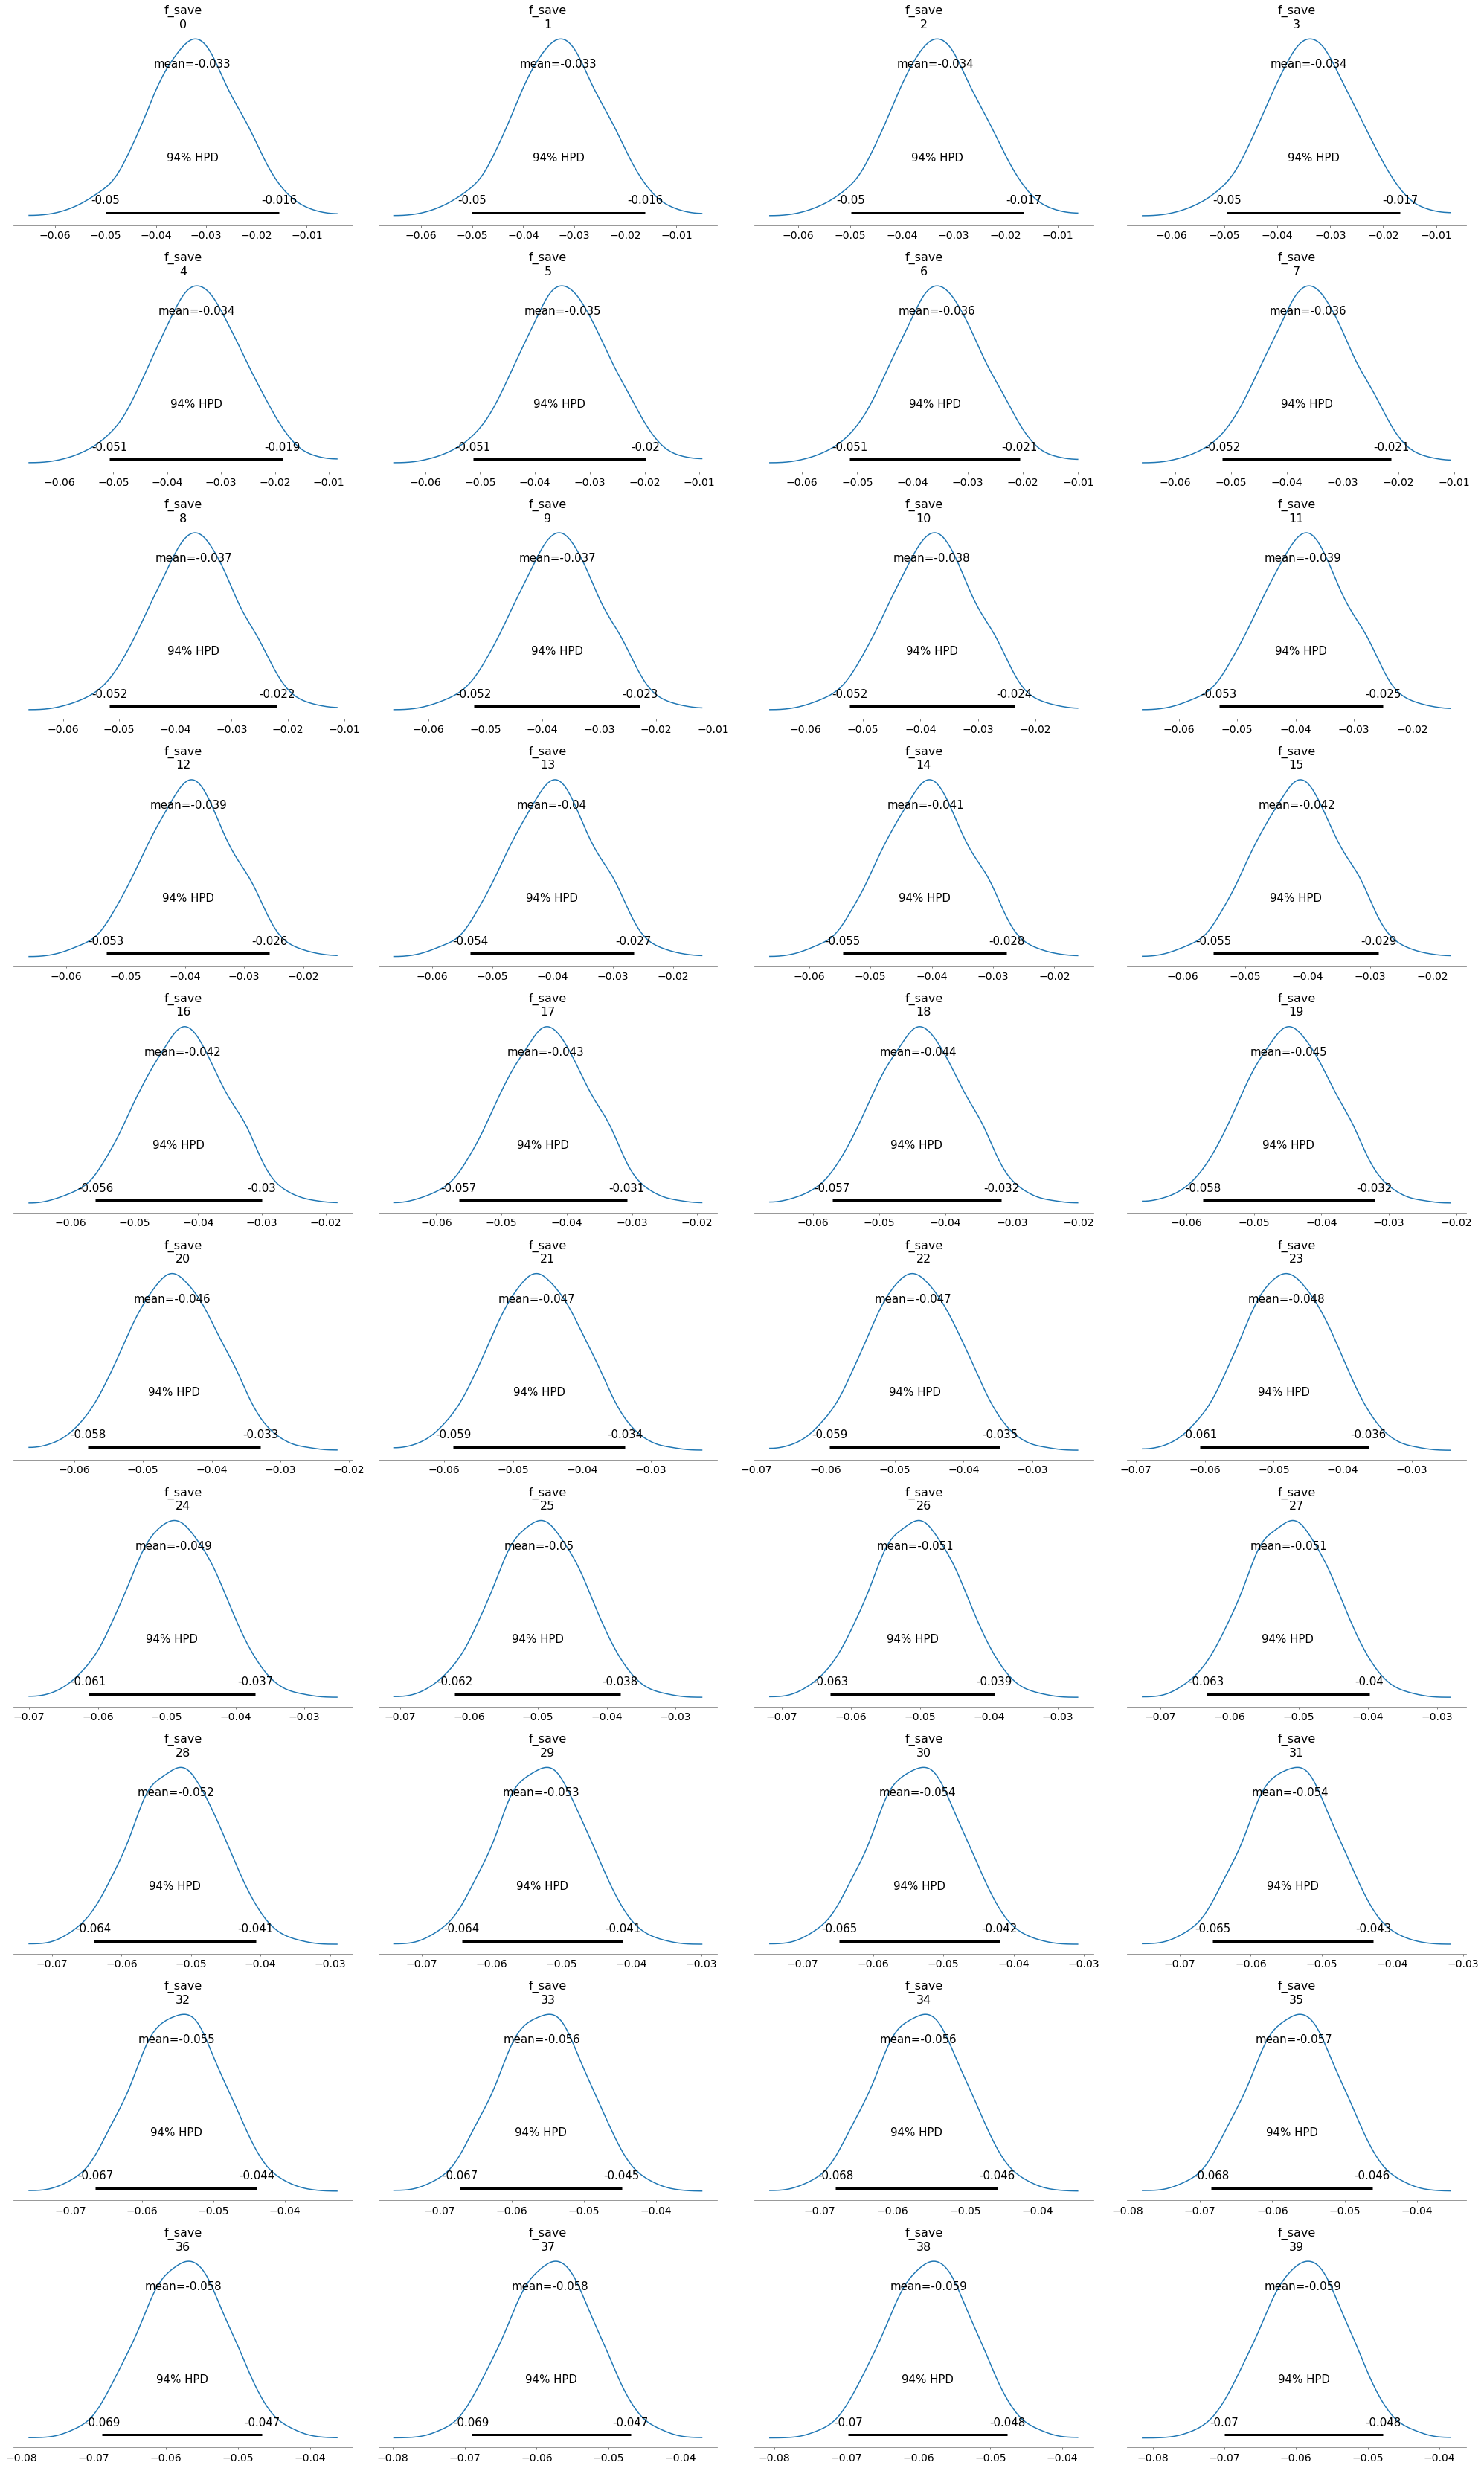

In [8]:
pm.plot_posterior(tracetransfer,'f_save');

In [11]:
summ=pm.summary(tracetransfer,'f_save');

print(summ.loc[:,'mean'])

/home/malte/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


f_save[0]     -0.033
f_save[1]     -0.033
f_save[2]     -0.034
f_save[3]     -0.034
f_save[4]     -0.034
               ...  
f_save[995]    0.084
f_save[996]    0.083
f_save[997]    0.082
f_save[998]    0.081
f_save[999]    0.080
Name: mean, Length: 1000, dtype: float64


In [20]:
f_plot=summ.loc[:,'mean']
ferr_plot=summ.loc[:,'sd']

In [22]:
ferr_plot[0:6]

f_save[0]    0.009
f_save[1]    0.009
f_save[2]    0.009
f_save[3]    0.009
f_save[4]    0.009
f_save[5]    0.008
Name: sd, dtype: float64

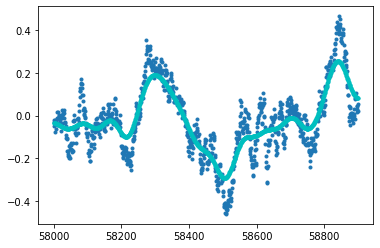

In [32]:
plt.errorbar(X_driv, f_plot, ferr_plot,fmt='c.',label='Fourier')
plt.plot(X_driv,f_driv,'.',label='data')